# A validation of the *phasespace* Python package on the Dalitz plot
## Esame di Analisi Dati in Fisica Subnucleare - 20 dicembre 2024

In this exercise we will study the Monte Carlo generation of the phasespace term of a three-body decay of a particle with mass $M = m_{123}$ into three daughter particles of masses $m_1$, $m_2$ and $m_3$.

To make the plots, we will consider [the decay $B^+ \to \pi^+ \pi^- K^+$](https://pdglive.lbl.gov/BranchingRatio.action?pdgid=S041.59&home=MXXX045), for which the masses listed above are:
 * $m_{123} = m(B^+) = 5279.34\ \mathrm{MeV}/c^2$
 * $m_1 = m_2 = m(\pi^+) = 139.57\ \mathrm{MeV}/c^2$
 * $m_3 = m(K^+) = 493.677\ \mathrm{MeV}/c^2$

What we are considering for this exercise is the generation of samples for the invariant masses of the first and second particle ($m_{12}$), and for the second and third particle ($m_{23}$).

This sampling is a primary ingredient for computing the decay amplitudes through the non-resonant channel or through resonances making the interactions between the hadrons in the final state relevant.
Indeed, in general, we can write that for a three-body decay the decay amplitude is written as (see for example [Equation 49.22 of the Particle Data Group Review of Particle Physics](https://pdg.lbl.gov/2024/reviews/rpp2024-rev-kinematics.pdf))
$$
\mathrm d \Gamma = \frac{1}{(2\pi)^3}{32M^3}\overline{|\mathcal M|}^2
\mathrm d m^2_{12} \mathrm d m^2_{23}
$$
where $\overline{|\mathcal M|}^2$ represents the *dynamics* of the decay while the rest of the equation account for the density of states in the final state (you may think of it as a change of variable in an integral).

So, obtain $\Gamma = \int \mathrm d \Gamma$ with a Monte Carlo integration you need to generate $m_{12}^2$ and $m_{23}^2$.
To generate $m_{12}$ and $m_{23}$ we have to make sure that:
 * their joint distribution (of the squared) $p(m_{12}^2, m_{23}^2)$ must be uniform
 * they should not violate energy and momentum conservation.

> In this exercise we will compare two different methods for sampling  $p(m_{12}^2, m_{23}^2)$:
> * using the `phasespace` Python package, that easily generalize to decays with more than three particles;
> * sampling a `uniform` distribution and then rejecting unphysical samples.
> Then we will compare the results obtained with the two methods by training a classifier on pseudo experiments trying to distinguish datasets generated with the two techniques.

## Part 1 - Sampling the phasespace with the `phasespace` package

Let's start with the sampling with the phasespace package.
We need to install it from PyPI with `pip`.

In [ ]:
!pip install -q phasespace

Then we import it together with numpy, pyplot.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import phasespace

The following code block defines a function to run the sampling of the phasespace for the $B^+ \to \pi^+ \pi^- K^+$ decay and return a tuple with:
 * `particles`, a dictionary in the form
   ```python
   {
      "p1": np.array([       # 4-momenta of daughter 1 with format (px, py, pz, E)

        [p1_x, p1_y, p1_z, p1_z],
        [p1_x, p1_y, p1_z, p1_z],
        ...
        [p1_x, p1_y, p1_z, p1_z],
      ],
      "p2": np.array([        # 4-momenta of daughter 2 with format (px, py, pz, E)
        [p2_x, p2_y, p2_z, p2_z],
        [p2_x, p2_y, p2_z, p2_z],
        ...
        [p2_x, p2_y, p2_z, p2_z],
      ],
      "p3": np.array([        # 4-momenta of daughter 3 with format (px, py, pz, E)
        [p3_x, p3_y, p3_z, p3_z],
        [p3_x, p3_y, p3_z, p3_z],
        ...
        [p3_x, p3_y, p3_z, p3_z],
      ]
   }
   ```
 * `weights`, a weight per sampled point to be used when computing the integral


In [ ]:
B_MASS = 5279.34
PION_MASS = 139.57018
KAON_MASS = 493.677


def generate_phasespace_momenta(m123, m1, m2, m3, n_events=1000):
  weights, particles = phasespace.nbody_decay(
      m123,
      [m1, m2, m3],
      names=['p1', 'p2', 'p3']
  ).generate(n_events=n_events)

  particles = {k: p.numpy() for k, p in particles.items()}
  weights = weights.numpy()
  return particles, weights

### Ex 1.1 - Compute the invariant masses

Given the four-vectors $p_1$, $p_2$, and $p_3$ of the three daughers, compute the invariant masses
$$
\begin{array}{ll}
m_{12} = &\!\! \sqrt{(E_1 + E_2)^2 - |\vec p_1 + \vec p_2|^2} \\
m_{23} = &\!\! \sqrt{(E_2 + E_3)^2 - |\vec p_2 + \vec p_3|^2} \\
\end{array}
$$

Then build the Dalitz plot: a scatter plot of $m_{12}^2 \perp m_{23}^2$.

> 💡 **Hint.** You may start from the following snippet
> ```python
> particles, weights = generate_phasespace_momenta(B_MASS, PION_MASS, PION_MASS, KAON_MASS, n_events=10000)
> p1x, p1y, p1z, p1e = ...
> p2x, p2y, p2z, p2e = ...
> p3x, p3y, p3z, p3e = ...
>
> m12 = np.sqrt(...)
> m23 = np.sqrt(...)
>
> plt.scatter( ... , s=1, color='k')
> plt.xlabel("$m_{\pi\pi}^2$ [MeV$^2$/$c^4$]")
> plt.ylabel("$m_{K\pi}^2$ [MeV$^2$/$c^4$]")
> plt.show()
> ```
>
> The expected output is not unlike the following
>
> 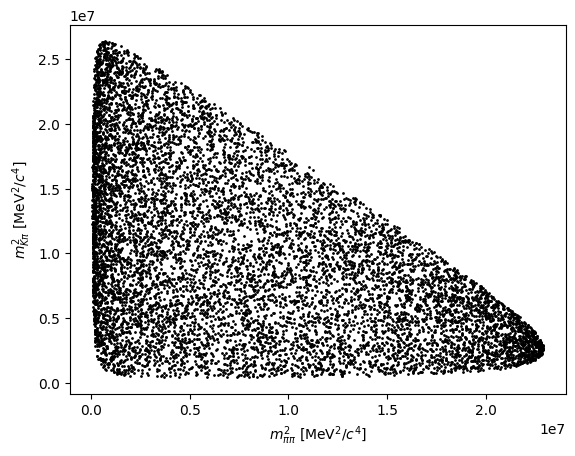

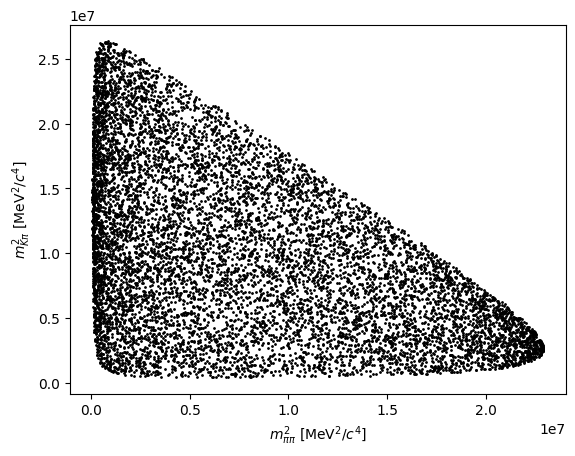

In [ ]:
# Solution
particles, weights = generate_phasespace_momenta(B_MASS, PION_MASS, PION_MASS, KAON_MASS, n_events=10000)
p1x, p1y, p1z, p1e = particles['p1'].T
p2x, p2y, p2z, p2e = particles['p2'].T
p3x, p3y, p3z, p3e = particles['p3'].T

m12 = np.sqrt((p1e + p2e)**2 - (p1x + p2x)**2 - (p1y + p2y)**2 - (p1z + p2z)**2)
m23 = np.sqrt((p2e + p3e)**2 - (p2x + p3x)**2 - (p2y + p3y)**2 - (p2z + p3z)**2)

plt.scatter(m12**2, m23**2, s=1, color='k')
plt.xlabel("$m_{\pi\pi}^2$ [MeV$^2$/$c^4$]")
plt.ylabel("$m_{K\pi}^2$ [MeV$^2$/$c^4$]")
plt.show()

### Ex. 1.2 - Achieve uniformity through rejection

The problem with the code above is that the sampled distribution is not uniform in $m_{12}^2 \perp m_{23}$. Samples must be weighted according to the provided `weight` to restore uniformity.

But we do not want a weighted sample, here, so we need to reject some samples, accepting others with a probability proportional to the `weight`.

As in the Monte Carlo accept/reject method, we will sample random numbers $u$ from a uniform distribution and retain events for which $u$ < `weight`.

For example, if $u \in [0, 1)$ to select over a sample of 10k events, one may expect to following Dalitz plot:

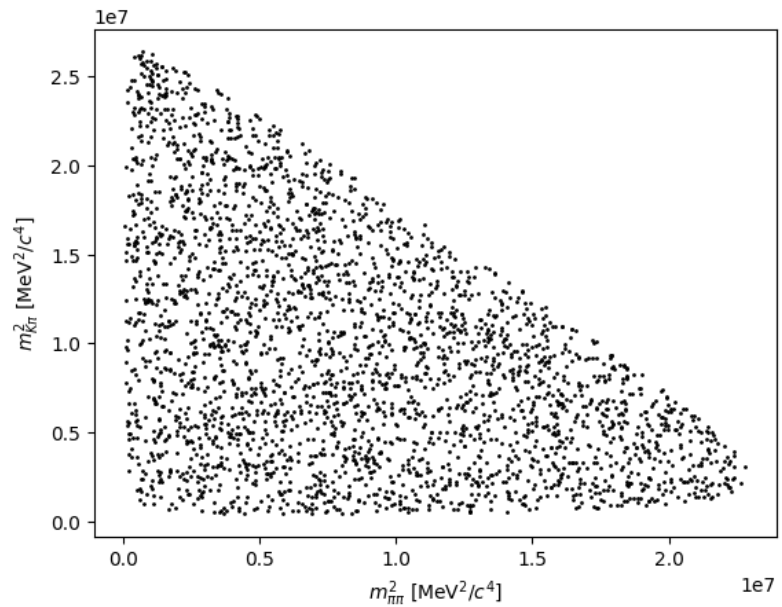


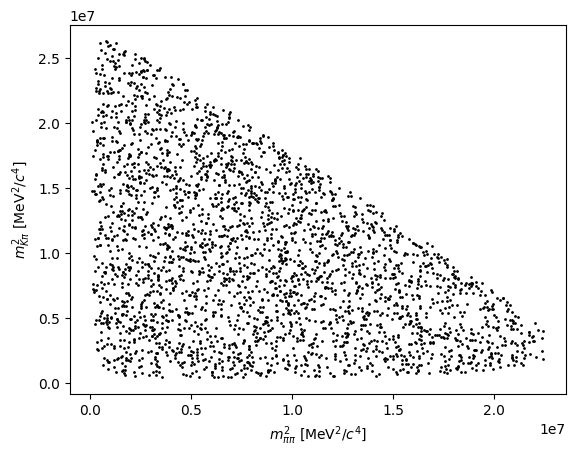

In [ ]:
# Solution
mask = np.random.uniform(0, 1, len(weights)) < weights

plt.scatter(m12[mask]**2, m23[mask]**2, s=1, color='k')

plt.xlabel("$m_{\pi\pi}^2$ [MeV$^2$/$c^4$]")
plt.ylabel("$m_{K\pi}^2$ [MeV$^2$/$c^4$]")
plt.show()

### Ex 1.3 - Fix the number of generated events

As we know, the problem with the Python implementations accept/rejection method is that we must define the number of events to generate in advance, and then a random number of them will be rejected, resulting in a random number of accepted samples. This may a represent a problem for statistical studies when the number of samples must be reproducible from an experiment to another.

To fix the number of accepted events to $N_{accepted}$ we will implement the following algorithm in a Python function:
 * we define a list of accepted chunks, say `chunk`
 * we generate a chunk of ten times the $10 \times N_{accepted}$
 * we run the acceptance/rejection selection based on the event weight
 * we append the array of accepted events to the accumulation list
 * we sum the events in the chunk in the list,
   * if they are at least $N_{accepted}$, we return the fist $N_{accepted}$;
   * else we iterate, generating a new chunk


> **💡Hint.** You may start from the following skeleton:
> ```python
> def generate_phasespace(m123, m1, m2, m3, n_events):
>   # define the accumulation list
>
>   while True:
>     # Generate the momenta with the phasespace package
>     particles, weights = generate_phasespace_momenta(B_MASS, PION_MASS, PION_MASS, KAON_MASS, n_events=n_events*10)
>     # Define the acceptance criterion and the corresponding boolean mask
>     mask = ...
>   
>     # Compute m12 and m23 as in Ex. 1.2
>     ...
>     m12 = ...
>     m23 = ...
>     
>     # Append the accepted samples
>     <your accumulation list>.append((np.c_[m12, m23][mask]))
>
>    
>     # Compute the number of accepted events so far
>     accepted_so_far = sum([len(c) for c in <your accumulation list>])
>     ...
>
>     if accepted_so_far >= n_events:
>       return np.concatenate(<your accumulation list, axis=0)[:n_events].T
>
> m12, m23 = generate_phasespace(B_MASS, PION_MASS, PION_MASS, KAON_MASS, 1000)
>
> # Draw the Dalitz plot...
> ```
>
> The result of this exercise should be similar to the following plot
>
> 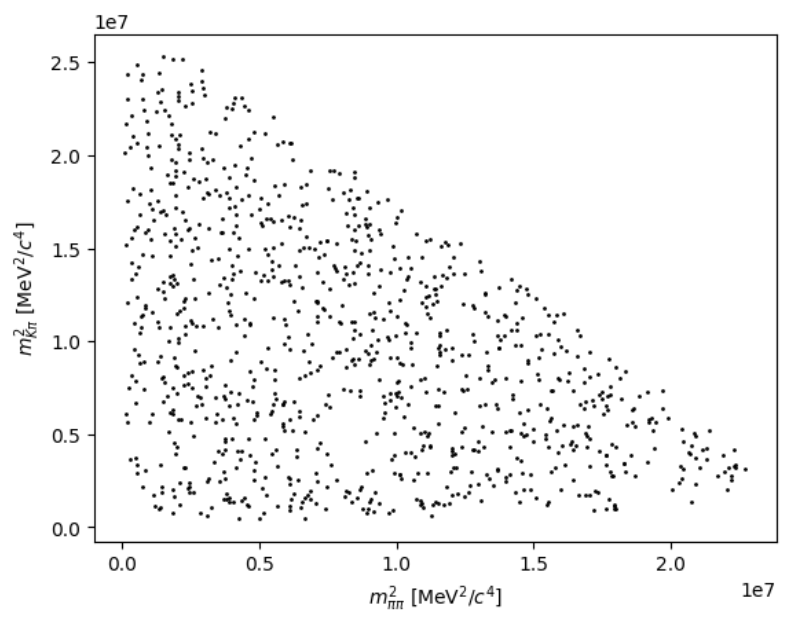

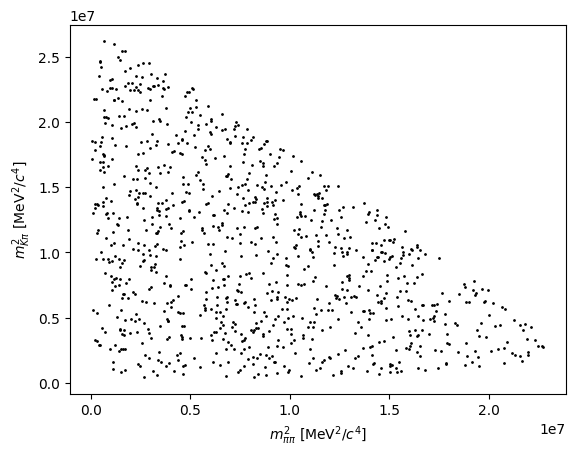

In [ ]:
# Solution
def generate_phasespace(m123, m1, m2, m3, n_events=1000):
  chunks = []

  while True:
    particles, weights = generate_phasespace_momenta(B_MASS, PION_MASS, PION_MASS, KAON_MASS, n_events=n_events*10)
    mask = np.random.uniform(0, 1, len(weights)) < weights
    p1x, p1y, p1z, p1e = particles['p1'][mask].T
    p2x, p2y, p2z, p2e = particles['p2'][mask].T
    p3x, p3y, p3z, p3e = particles['p3'][mask].T

    m12 = np.sqrt((p1e + p2e)**2 - (p1x + p2x)**2 - (p1y + p2y)**2 - (p1z + p2z)**2)
    m23 = np.sqrt((p2e + p3e)**2 - (p2x + p3x)**2 - (p2y + p3y)**2 - (p2z + p3z)**2)

    chunks.append((np.c_[m12, m23]))

    if sum([len(c) for c in chunks]) >= n_events:
      return np.concatenate(chunks, axis=0)[:n_events].T

m12, m23 = generate_phasespace(B_MASS, PION_MASS, PION_MASS, KAON_MASS, 1000)

plt.scatter(m12**2, m23**2, s=1, color='k')
plt.xlabel("$m_{\pi\pi}^2$ [MeV$^2$/$c^4$]")
plt.ylabel("$m_{K\pi}^2$ [MeV$^2$/$c^4$]")

plt.show()

## Part 2 - Rejecting unphysical events

The alternative method we are implementing in this second part is a bit simpler. We sample random numbers from a uniform distribution and then we reject those corresponding to unphysical conditions, violating the energy or momentum conservation.
> ⚠️ Beware that this method would only work for three particles in the final state, it is never used in real life.



### Ex. 2.1 - Compute the kinematic boundaries

Let's start by computing the upper and lower boundaries for $m_{23}$ given $m_{123}$, $m_1$, $m_2$, $m_3$ and $m_{12}$.

Following the prescriptions of the [Particle Data Group in Equation 44.23 of their Review](https://pdg.lbl.gov/2024/reviews/rpp2024-rev-kinematics.pdf), we write that
$$
(m_{23}^2)_{\mathrm{max}} = (E_2^* + E_3^*)^2 - \big(\sqrt{E_2^{*2} - m_2^2} - \sqrt{E_3^{*2} - m_3^2}\big)^2
$$
$$
(m_{23}^2)_{\mathrm{min}} = (E_2^* + E_3^*)^2 - \big(\sqrt{E_2^{*2} - m_2^2} + \sqrt{E_3^{*2} - m_3^2}\big)^2
$$
with
$$
E_2^* = \frac{m_{12}^2 - m_1^2 + m_2^2}{2 m_{12}}
$$
and
$$
E_3^* = \frac{m_{123}^2 - m_{12}^2 - m_3^2}{2 m_{12}}
$$

Implement a function `compute_m23_minmax()` computing these boundaries for an array of values for $m_{12}$.
Check it provides the correct boundaries by superposing it to the Dalitz plot of Ex. 1.1.

```python
x_axis = np.linspace(m1 + m2, m123 - m3, 1000)
m23_min, m23_max = compute_m23_minmax(m123, m1, m2, m3, x_axis)
# Add here the scatter plot of Ex. 1.1
...

plt.plot(x_axis**2, m23_min**2, 'b')
plt.plot(x_axis**2, m23_max**2, 'r')
plt.xlabel("$m_{\pi\pi}^2$ [MeV$^2$/$c^4$]")
plt.ylabel("$m_{K\pi}^2$ [MeV$^2$/$c^4$]")
plt.show()
```

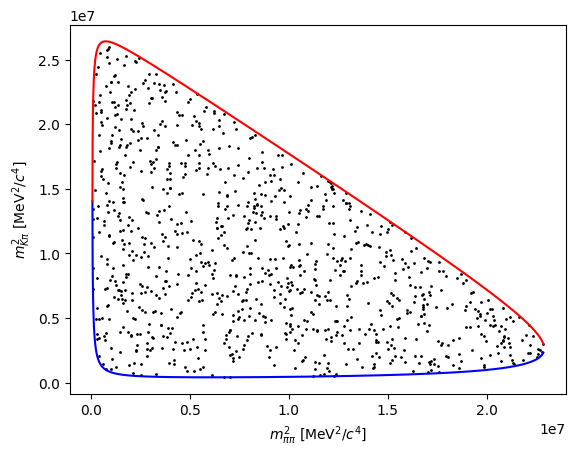

<ipython-input-19-dea3a5e4768d>:14: RuntimeWarning: invalid value encountered in sqrt
  m23_min = np.sqrt((E2 + E3)**2 - (np.sqrt(E2**2 - m2**2) + np.sqrt(E3**2 - m3**2))**2)
<ipython-input-19-dea3a5e4768d>:15: RuntimeWarning: invalid value encountered in sqrt
  m23_max = np.sqrt((E2 + E3)**2 - (np.sqrt(E2**2 - m2**2) - np.sqrt(E3**2 - m3**2))**2)


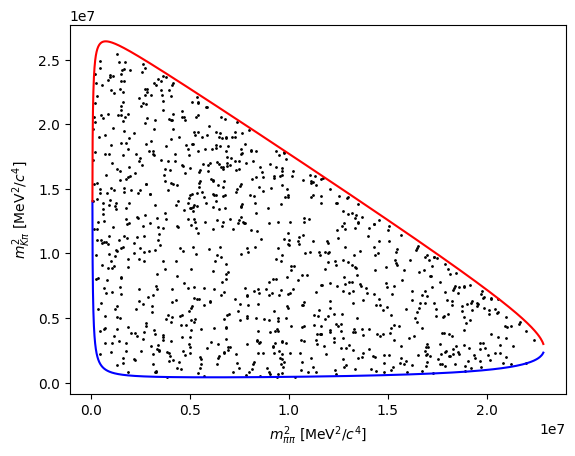

In [ ]:
# Solution
m1 = PION_MASS
m2 = PION_MASS
m3 = KAON_MASS
m123 = B_MASS

m12, m23 = generate_phasespace(B_MASS, PION_MASS, PION_MASS, KAON_MASS, 1000)
plt.scatter(m12**2, m23**2, s=1, color='k')


def compute_m23_minmax(m123, m1, m2, m3, m12):
  E2 = (m12**2 - m1**2 + m2**2)/(2*m12)
  E3 = (m123**2 - m12**2 - m3**2)/(2*m12)
  m23_min = np.sqrt((E2 + E3)**2 - (np.sqrt(E2**2 - m2**2) + np.sqrt(E3**2 - m3**2))**2)
  m23_max = np.sqrt((E2 + E3)**2 - (np.sqrt(E2**2 - m2**2) - np.sqrt(E3**2 - m3**2))**2)
  return m23_min, m23_max


x_axis = np.linspace(m1 + m2, m123 - m3, 1000)
m23_min, m23_max = compute_m23_minmax(m123, m1, m2, m3, x_axis)
plt.plot(x_axis**2, m23_min**2, 'b')
plt.plot(x_axis**2, m23_max**2, 'r')
plt.xlabel("$m_{\pi\pi}^2$ [MeV$^2$/$c^4$]")
plt.ylabel("$m_{K\pi}^2$ [MeV$^2$/$c^4$]")
plt.show()

### Ex. 2.2 - Generate squared masses uniformly, and reject samples outside the physical boundaries

Now that you have the boundaries implemented, you can generate squared masses sampling a uniform distribution.
You can then compare discard sample falling outside of the boundaries computed in the previous exercise.

To visualize this step, consider the following graphics.

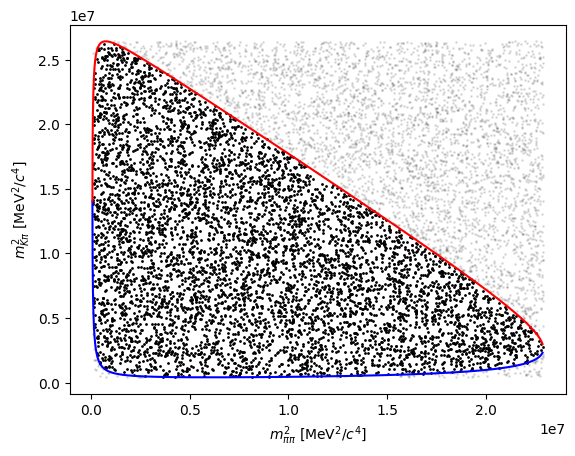


<ipython-input-19-dea3a5e4768d>:14: RuntimeWarning: invalid value encountered in sqrt
  m23_min = np.sqrt((E2 + E3)**2 - (np.sqrt(E2**2 - m2**2) + np.sqrt(E3**2 - m3**2))**2)
<ipython-input-19-dea3a5e4768d>:15: RuntimeWarning: invalid value encountered in sqrt
  m23_max = np.sqrt((E2 + E3)**2 - (np.sqrt(E2**2 - m2**2) - np.sqrt(E3**2 - m3**2))**2)


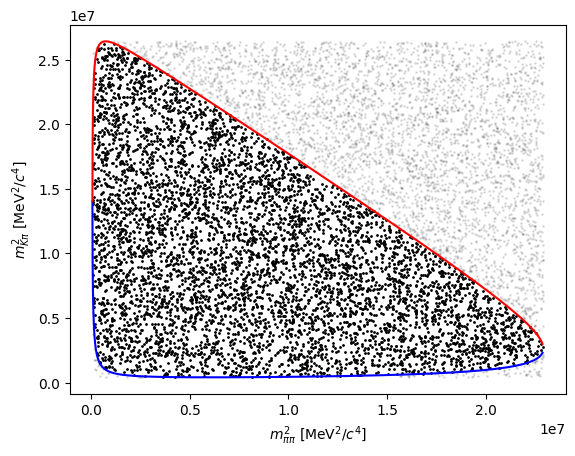

In [ ]:
# Solution
m12 = np.sqrt(np.random.uniform((m1 + m2)**2, (m123 - m3)**2, 10000))
m23 = np.sqrt(np.random.uniform((m2 + m3)**2, (m123 - m1)**2, 10000))

m23_min, m23_max = compute_m23_minmax(m123, m1, m2, m3, m12)
mask = (m23 > m23_min) & (m23 < m23_max)
plt.scatter(m12[mask]**2, m23[mask]**2, s=1, color='k')
plt.scatter(m12[~mask]**2, m23[~mask]**2, s=1, color='k', alpha=0.1)

x_axis = np.linspace(m1 + m2, m123 - m3, 1000)
m23_min, m23_max = compute_m23_minmax(m123, m1, m2, m3, x_axis)
plt.plot(x_axis**2, m23_min**2, 'b')
plt.plot(x_axis**2, m23_max**2, 'r')


plt.xlabel("$m_{\pi\pi}^2$ [MeV$^2$/$c^4$]")
plt.ylabel("$m_{K\pi}^2$ [MeV$^2$/$c^4$]")
plt.show()

### Ex. 2.3 - Fix the number of generated events, again

Implement the same logics as in Exercise 1.3 to fix the number of accepted events.

<ipython-input-19-dea3a5e4768d>:14: RuntimeWarning: invalid value encountered in sqrt
  m23_min = np.sqrt((E2 + E3)**2 - (np.sqrt(E2**2 - m2**2) + np.sqrt(E3**2 - m3**2))**2)
<ipython-input-19-dea3a5e4768d>:15: RuntimeWarning: invalid value encountered in sqrt
  m23_max = np.sqrt((E2 + E3)**2 - (np.sqrt(E2**2 - m2**2) - np.sqrt(E3**2 - m3**2))**2)


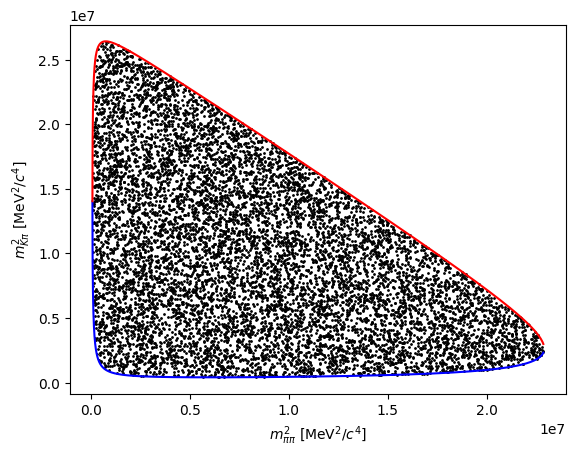

In [ ]:
# Solution
def my_generate_phasespace(m123, m1, m2, m3, n_events=1000):
  chunks = []
  while True:
    m12 = np.sqrt(np.random.uniform((m1 + m2)**2, (m123 - m3)**2, n_events))
    m23 = np.sqrt(np.random.uniform((m2 + m3)**2, (m123 - m1)**2, n_events))

    m23_min, m23_max = compute_m23_minmax(m123, m1, m2, m3, m12)
    mask = (m23 > m23_min) & (m23 < m23_max)

    chunks.append(np.c_[m12, m23][mask])
    if sum([len(c) for c in chunks]) > n_events:
      return np.concatenate(chunks)[:n_events].T

m12, m23 = my_generate_phasespace(m123, m1, m2, m3, 10000)
plt.scatter(m12**2, m23**2, s=1, color='k')
m23_min, m23_max = compute_m23_minmax(m123, m1, m2, m3, x_axis)

plt.plot(x_axis**2, m23_min**2, 'b')
plt.plot(x_axis**2, m23_max**2, 'r')
plt.xlabel("$m_{\pi\pi}^2$ [MeV$^2$/$c^4$]")
plt.ylabel("$m_{K\pi}^2$ [MeV$^2$/$c^4$]")
plt.show()

## Part 3 - Assess the agreement between the samples generated with the two methods

Implement a classifier with a [`Random Forest` from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to try distinguishing two samples generated **with the same method**, for example with uniform distributions with rejected unphysical events as developed in Part 2.

Then compute the [Area Under the ROC curve (ROC-AUC)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

The ROC-AUC obtained from a classifier trained to distinguish two statistically identical samples provides the distribution of the *null hypothesis*.
Then, we will repeat the same exercise training the same classifier on the samples obtained with the two different algorithms and we will compare the ROC-AUC with the distribution of the same test-statistic on the null hypothesis.



### Ex. 3.1 - Train a Random Forest from scikit-learn

Starting from the following skeleton, train the classifier and compute the Area Under the ROC curve.

The Random Forest should:
 * be composed of 5 decision trees;
 * not feature leaves with less than 50 entries.

```python
# Import the RandomForest Classifier from scikit-learn
...
# Import the function to compute the ROC-AUC from scikit-learn
...

# Define a list to accumulate the results
auc_scores = []

# Run 100 experiment
for i_experiment in range(100):
  # Create the scikit-learn object
  rf = ...

  # Generate the phasespace with one of the two methods
  m12_1_train, m23_1_train = my_generate_phasespace(m123, m1, m2, m3, 10000)
  # Generate the phasespace with THE SAME method
  m12_2_train, m23_2_train = my_generate_phasespace(m123, m1, m2, m3, 10000)

  # Concatenate the two samples corresponding to the two
  # generations into a single sample.
  m12_train = np.concatenate([m12_1_train, m12_2_train])
  m23_train = np.concatenate([m23_1_train, m23_2_train])

  # Repeat the generation to create a validation sample
  m12_1_test, m23_1_test = my_generate_phasespace(m123, m1, m2, m3, 10000)
  m12_2_test, m23_2_test = my_generate_phasespace(m123, m1, m2, m3, 10000)
  m12_test = np.concatenate([m12_1_test, m12_2_test])
  m23_test = np.concatenate([m23_1_test, m23_2_test])

  # Create the labels, we will label 1 the samples obtained
  # from the first generation and 0 those from the second.
  y_train = np.concatenate([np.ones_like(m12_1_train), np.zeros_like(m12_2_train)])
  # Same thing for the test sample
  y_test = np.concatenate([np.ones_like(m12_1_test), np.zeros_like(m12_2_test)])

  # Train the model
  ...

  # Compute the ROC-AUC
  score = ...

  # Append the ROC-AUC in the accumulation list
  auc_scores.append(score)

# Plot the histogram of the null hypothesis.
plt.hist(auc_scores, bins=20, label="Null hypothesis")
plt.xlabel("Area under the ROC curve")
plt.legend()
plt.show()
```

The output of this block should be similar to

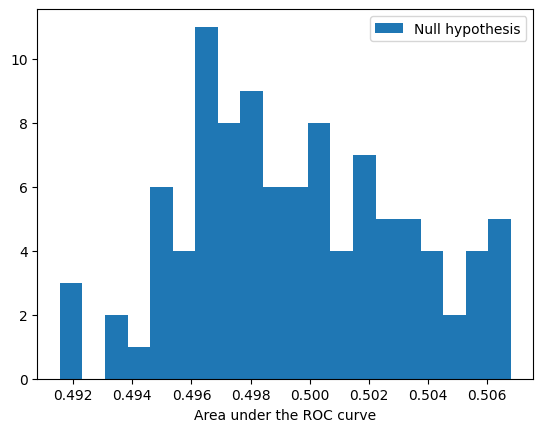

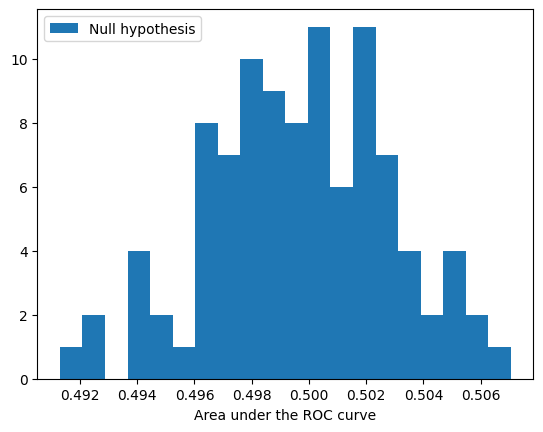

In [ ]:
# Solution
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

auc_scores = []

for i_experiment in range(100):
  rf = RandomForestClassifier(n_estimators=5, min_samples_leaf=50)
  m12_1_train, m23_1_train = my_generate_phasespace(m123, m1, m2, m3, 10000)
  m12_2_train, m23_2_train = my_generate_phasespace(m123, m1, m2, m3, 10000)
  m12_train = np.concatenate([m12_1_train, m12_2_train])
  m23_train = np.concatenate([m23_1_train, m23_2_train])

  m12_1_test, m23_1_test = my_generate_phasespace(m123, m1, m2, m3, 10000)
  m12_2_test, m23_2_test = my_generate_phasespace(m123, m1, m2, m3, 10000)
  m12_test = np.concatenate([m12_1_test, m12_2_test])
  m23_test = np.concatenate([m23_1_test, m23_2_test])

  y_train = np.concatenate([np.ones_like(m12_1_train), np.zeros_like(m12_2_train)])
  y_test = np.concatenate([np.ones_like(m12_1_test), np.zeros_like(m12_2_test)])

  rf.fit(np.c_[m12_train, m23_train], y_train)
  score = roc_auc_score(y_test, rf.predict(np.c_[m12_test, m23_test]))

  auc_scores.append(score)

plt.hist(auc_scores, bins=20, label="Null hypothesis")
plt.xlabel("Area under the ROC curve")
plt.legend()
plt.show()

### Ex. 3.2 - Compare the samples obtained with the two different methods

Building on top of the previous exercise, repeat the comparison of two samples, but this time use the two different methods implemented above to generate the two samples used to train (and test) the random forest.

You should obtain a figure similar to the following one.

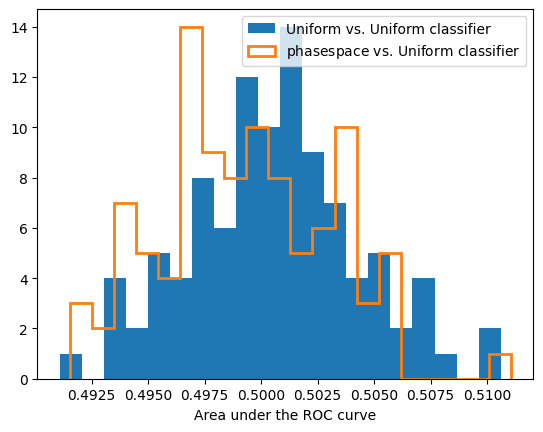

> ⚠️ **Warning!** Running 100 experiments may require a few minutes. Ensure your code works with a smaller number of experiments, and at the very end, scale up to 100.

In [ ]:
# Solution
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from tqdm import trange

auc_scores_h0 = []
auc_scores_h1 = []

for i_experiment in trange(100):
  for accumulator, gen_function in [
      (auc_scores_h0, my_generate_phasespace),
      (auc_scores_h1, generate_phasespace),
  ]:
    rf = RandomForestClassifier(n_estimators=5, min_samples_leaf=50)
    m12_1_train, m23_1_train = my_generate_phasespace(m123, m1, m2, m3, 10000)
    m12_2_train, m23_2_train = gen_function(m123, m1, m2, m3, 10000)
    m12_train = np.concatenate([m12_1_train, m12_2_train])
    m23_train = np.concatenate([m23_1_train, m23_2_train])

    m12_1_test, m23_1_test = my_generate_phasespace(m123, m1, m2, m3, 10000)
    m12_2_test, m23_2_test = gen_function(m123, m1, m2, m3, 10000)
    m12_test = np.concatenate([m12_1_test, m12_2_test])
    m23_test = np.concatenate([m23_1_test, m23_2_test])

    y_train = np.concatenate([np.ones_like(m12_1_train), np.zeros_like(m12_2_train)])
    y_test = np.concatenate([np.ones_like(m12_1_test), np.zeros_like(m12_2_test)])

    rf.fit(np.c_[m12_train, m23_train], y_train)
    score = roc_auc_score(y_test, rf.predict(np.c_[m12_test, m23_test]))

    accumulator.append(score)

100%|██████████| 100/100 [04:11<00:00,  2.51s/it]


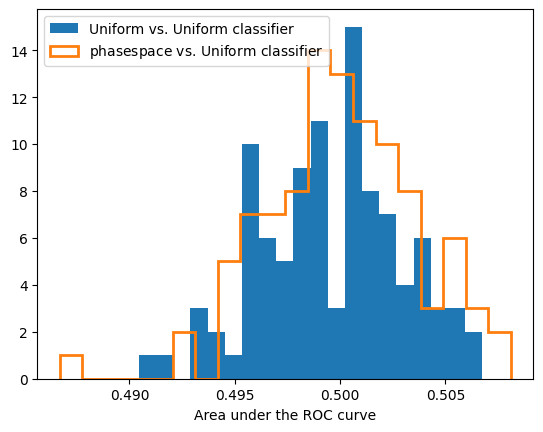

In [ ]:
# Solution
plt.hist(auc_scores_h0, bins=20, label="Uniform vs. Uniform classifier")
plt.hist(auc_scores_h1, bins=20, label="$\mathrm{phasespace}$ vs. Uniform classifier", histtype='step', linewidth=2)
plt.xlabel("Area under the ROC curve")
plt.legend()
plt.show()

## Conclusion

In this exercise we reviewed of methods to sample the phasespace of a three-body decay, the `phasespace` package from PyPI and an in-house rejection method based on the boundaries of the Dalitz plot computed from kinematical constraints.

The two methods were compared by training a binary classifier and to distinguish the generated samples and comparing the ROC-AUC with the distribution of the ROC-AUC of the same classifier trained to classify samples obtained from the same algorithm.

The distributions of ROC-AUC obtained classifying samples from different algorithms is consistent with the distribution obtained classifying identical samples, which confirms the samples obtained with the methods are statistically equivalent.

